# Introduction

This notebook contains a Transformer for performing lip-reading on video English speakers.

# 1: Import Data

In [20]:
"""
Mount Google Drive to import data.
"""

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
"""
Locate and unzip data in individual user's Google Drive.
"""

# !unzip /content/drive/MyDrive/Senior/Spring/EC523/FinalProject/ec523/data.zip
# !unzip /content/drive/MyDrive/School/Graduate/Classes/2024\ Spring/EC523\ Deep\ Learning/data.zip
!unzip /content/drive/MyDrive/data.zip


Archive:  /content/drive/MyDrive/data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/.DS_Store          
  inflating: data/annotations/.DS_Store  
  inflating: data/videos/prwq3s.mpg  
  inflating: data/videos/pbib8p.mpg  
  inflating: data/videos/lrae3s.mpg  
  inflating: data/videos/pgid6p.mpg  
  inflating: data/videos/pbao8n.mpg  
  inflating: data/videos/prbx3s.mpg  
  inflating: data/videos/lbbk6p.mpg  
  inflating: data/videos/bgwu6n.mpg  
  inflating: data/videos/sbig6p.mpg  
  inflating: data/videos/pgby5s.mpg  
  inflating: data/videos/bras8p.mpg  
  inflating: data/videos/sgiczp.mpg  
  inflating: data/videos/lrwl7a.mpg  
  inflating: data/videos/bbbz8n.mpg  
  inflating: data/videos/bram3s.mpg  
  inflating: data/videos/pwwk7a.mpg  
  inflating: data/videos/bbws8n.mpg  
  inflating: data/videos/brbtzn.mpg  
  inflating: data/videos/bwwbzp.mpg  
  inflating: data/videos/lrbr5s.mpg  
  inflating: data/videos/bgwu9a.mpg  
  inflating: dat

# 2: Visualize Data

mkdir: cannot create directory ‘example_data’: File exists


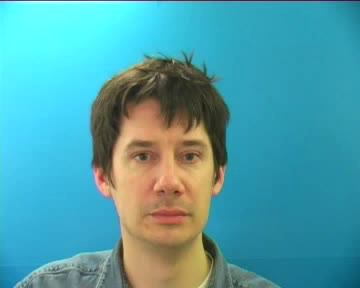

Sample Video: bwwu3a.mpg
Corresponding Annotation: bwwu3a.align


In [13]:
"""
Define data directories and load raw sample data to visualize.
"""

from google.colab.patches import cv2_imshow
import os
import cv2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy("mixed_bfloat16")

data_dir        = os.path.join('/content', 'data')
videos_dir      = os.path.join(str(data_dir), 's1')
annotations_dir = os.path.join(data_dir, 'alignments', 's1')
example_data    = os.path.join('/content', 'example_data')
!mkdir example_data


# Func to find corresponding annotation file for a video file
def find_annotation_file(video_file):
    base_name       = os.path.splitext(video_file)[0]
    annotation_file = base_name + '.align'

    return annotation_file


# Get data
sample_video       = os.listdir(videos_dir)[0]
example_video_path = os.path.join(videos_dir, sample_video)

sample_annotation  = find_annotation_file(sample_video)
annotation_path    = os.path.join(annotations_dir, sample_annotation)

with open(annotation_path, 'r') as annotation_file:
    annotation_content = annotation_file.read()

# Display frame from sample video
cap = cv2.VideoCapture(example_video_path)
ret, frame = cap.read()
cap.release()
cv2_imshow(frame)

# Print corresponding data
print("Sample Video:", sample_video)
print("Corresponding Annotation:", sample_annotation)


# 3: Load Data


In [14]:
"""
Consolidated global parameters and model hyper-parameters.
"""

# Static LipNet params
words_per_clip  = 8
vocab_size      = 53
frames_per_clip = 75  # Generally 75 (few have slightly different frame counts)
video_cnt       = 1000

# Other Parameters
frame_width  = 80     # originally 224
frame_height = 40     # originally 224
vert_scale   = 1.3
color        = False  # whether to convert to grayscale

# Model params
num_layers    = 2
embedding_dim = 16
num_heads     = 2
feedfor_dim   = 16
dropout_rate  = 0.5
learning_rate = 0.001  # 0.001 seems best

# Training data params
sample_size = 100   # 512 for now (max is 1000); use TPU
batch_size  = 1    # TODO: ?
epochs      = 1     # 5 usually sufficient to see pattern
train_ratio = 0.95  # % for training and validation; rest for testing

# Keywords/Tokens in LipNet dataset
words = ['a', 'again', 'at', 'b', 'bin', 'blue', 'by', 'c', 'd', 'e',
         'eight', 'f', 'five', 'four', 'g', 'green', 'h', 'i', 'in', 'j',
         'k', 'l', 'lay', 'm', 'n', 'nine', 'now', 'o', 'one', 'p',
         'place', 'please', 'q', 'r', 'red', 's', 'set', 'seven', 'sil', 'six',
         'soon', 'sp', 't', 'three', 'two', 'u', 'v', 'white', 'with', 'x',
         'y', 'z', 'zero']


In [15]:
"""
Tokenize annotations, define funcs to load data, and print the data dims.
"""

import math
import cv2
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Unique syllable tokens in LipNet dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)


def load_video_frames(video_path, num_frames=frames_per_clip,
                      target_size=(frame_width, math.floor(frame_height*vert_scale)),
                      batch_size=batch_size):
    frames = []
    cap    = cv2.VideoCapture(video_path)
    count  = 0
    while True:
        ret, frame = cap.read()
        if not ret or count >= num_frames:
            break
        frame = cv2.resize(frame, target_size)
        frame = frame.astype(np.float16) / 255.0
        frames.append(frame)
        count += 1
    cap.release()
    while len(frames) < num_frames:
        frames.append(np.zeros_like(frames[0]))

    frames = np.array(frames)

    return frames


# Load and tokenize annotations
def load_annotation(annotation_file, max_length=8):
    with open(annotation_file, 'r') as file:
        annotations = file.readlines()

    # Filter out all annotation text other than keyword
    trimmed_annotations = []
    for annotation in annotations:
        trimmed_annotations.append(annotation.strip().split()[2])

    # Tokenize the words to sequences (lists) of letter tokens (and truncate)
    sequence   = [token[0] for token in tokenizer.texts_to_sequences(trimmed_annotations)]
    padded_seq = pad_sequences([sequence], maxlen=max_length, padding='post', truncating='post')[0]

    # print(annotation_file, '...')
    # print('raw annotations: ',    annotations)
    # print('trimmed annotations:', trimmed_annotations)
    # print('sequences:',           sequence)
    # print('padded_sequences: ',   padded_seq)

    return padded_seq


# Print sample frames data
sample_video_path = os.path.join(videos_dir, sample_video)  # sample video path
video_frames      = load_video_frames(sample_video_path)    # load video frames
print("Number of frames in the video:", len(video_frames))
print("Shape of each frame:", video_frames[0].shape)
# print("Video frames example: \n", video_frames[0])

# Print sample annotation data
max_length = 8  # 6 words and a 'sil' on either end...
annotation_sequences = load_annotation(annotation_path, max_length=max_length)
print("\nTotal number of tokens: ", len(words))  # 53
print("Preprocessed annotation sequences shape:", annotation_sequences.shape)
print("Annotation sequences example: \n", annotation_sequences)


Number of frames in the video: 75
Shape of each frame: (52, 80, 3)

Total number of tokens:  53
Preprocessed annotation sequences shape: (8,)
Annotation sequences example: 
 [39  5 48 49 46 44  2 39]


# 4: Pre-Process Data

In [16]:
"""
Define funcs to perform pre-processing on both video frames and annotations.
"""

import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cv2


# Use Haar cascade for lip detection
# More reliable to track entire face then crop to lips...
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
lips_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
# eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')


def process_video_file(path: str, save_frames: bool = False):
    """
    TODO: Maybe use average background color (backdrop is cyan) to check accuracy; default to center if close to cyan...
    """

    # Load video
    cap = cv2.VideoCapture(path)  # e.g. /content/data/videos/bbaf2n.mpg

    tensors_list = []

    frame_count = 0
    while True:

        # Read frame from vid
        ret, raw = cap.read()
        if not ret or frame_count >= frames_per_clip:
            break

        # Convert to grey scale
        frame = raw
        if not color:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Face detection
        for x in reversed(range(5, 8)):  # lower conditions as needed to find best match
            face = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=x,
                                                 minSize=(60,  30),
                                                 maxSize=(120, 60))
            if len(face) > 0:
                break
        if len(face) == 0:  # if still no match, use static vals
            face = [[50, 150, 200, 100]]
        (x, y, w, h) = face[0]

        # Lips detection
        face = frame[y:y+h, x:x+w]
        for x in reversed(range(5, 8)):
            lips = lips_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=x,
                                                minSize=(60,  30),
                                                maxSize=(120, 60))
            if len(lips) > 0:
                break
        if len(lips) == 0:
            lips = [[50, 150, 200, 100]]
        (x, y, w, h) = lips[0]

        # Store normalized, grayscaled, and uniformly cropped
        frame = frame[y:y+h, x:x+w]
        frame = cv2.normalize(frame, frame, 0, 100, cv2.NORM_MINMAX)
        frame = cv2.resize(frame, (frame_width, frame_height))

        tensors_list.append(frame)

        if save_frames:

            # Save to file
            cv2.imwrite(os.path.join(example_data, f'frame_{frame_count:02d}.jpg'), frame)

            # Save some of the color images with the bounding box...
            if frame_count % 10 == 0:
                cv2.rectangle(raw, (x, y), (x+w, y+h), (0, 200, 0), 2)  # draws rectangle
                cv2.imwrite(os.path.join(example_data, f'frame_{frame_count:02d}_box.jpg'), raw)

        frame_count += 1

    cap.release()

    while len(tensors_list) < frames_per_clip:
        tensors_list.append(np.zeros_like(tensors_list[0]))

    # print(f"Finished processing video; {frame_count} frames saved in:", output_dir)
    # print(f'\nvideo_tensor ({type(video_tensor)}, {video_tensor.shape}): \n', video_tensor)

    return tensors_list


# Preprocess data (resize frames, tokenize annotations)
def preprocess_data(video_paths, annotation_paths, words_per_clip):
    video_cnt        = len(video_paths)
    annotation_cnt   = len(annotation_paths)
    video_dims       = (frames_per_clip, frame_height, frame_width)
    if color:
        video_dims   = (frames_per_clip, frame_height, frame_width, 3)
    annotation_dims  = (words_per_clip, )
    # print(video_dims)
    assert video_cnt == annotation_cnt

    video_frames = []
    for i, path in enumerate(video_paths):
        if i % 5 == 0:
            print(f'Video: {i} / {video_cnt}')
        frames = process_video_file(path)
        frames = np.array(frames[:frames_per_clip])
        # print(frames.shape)
        assert frames.shape == video_dims
        video_frames.append(frames)

    annotations = []
    for i, path in enumerate(annotation_paths):
        if i % 5 == 0:
            print(f'Annotation: {i} / {annotation_cnt}')
        annotation_set = np.array(load_annotation(path, words_per_clip))
        # print(annotation_set.shape)
        assert annotation_set.shape == annotation_dims
        annotations.append(annotation_set)

    print('Video_frames shape:\n', video_frames[3].shape)
    print('Annotation shape:  \n', annotations[3].shape)

    return np.array(video_frames), np.array(annotations)


# Generate example images
# Save example pre-processed frames to /content/example_data
# Every 10th frame will be the uncropped version with the Haar classifier bounding
result = np.array(process_video_file(example_video_path, True))  # Same example as above
print('Example pre-processed video tensor shape: ', result.shape)


Example pre-processed video tensor shape:  (75, 40, 80)


In [17]:
"""
Pre-process all of the data, storing it in arrays.
"""

import os
import random
import shutil

# List video files, then generate corresponding list of annotations
video_files      = [os.path.join(videos_dir, file) for file in os.listdir(videos_dir) if file.endswith('.mpg')]
annotation_files = [os.path.join(annotations_dir, os.path.basename(file).replace('.mpg', '.align')) for file in video_files]

# Extract pre-processed frames and annotations
all_video_frames, all_annotations = preprocess_data(video_files[:sample_size],
                                                    annotation_files[:sample_size],
                                                    words_per_clip)


Video: 0 / 100
Video: 5 / 100
Video: 10 / 100
Video: 15 / 100
Video: 20 / 100
Video: 25 / 100
Video: 30 / 100
Video: 35 / 100
Video: 40 / 100
Video: 45 / 100
Video: 50 / 100
Video: 55 / 100
Video: 60 / 100
Video: 65 / 100
Video: 70 / 100
Video: 75 / 100
Video: 80 / 100
Video: 85 / 100
Video: 90 / 100
Video: 95 / 100
Annotation: 0 / 100
Annotation: 5 / 100
Annotation: 10 / 100
Annotation: 15 / 100
Annotation: 20 / 100
Annotation: 25 / 100
Annotation: 30 / 100
Annotation: 35 / 100
Annotation: 40 / 100
Annotation: 45 / 100
Annotation: 50 / 100
Annotation: 55 / 100
Annotation: 60 / 100
Annotation: 65 / 100
Annotation: 70 / 100
Annotation: 75 / 100
Annotation: 80 / 100
Annotation: 85 / 100
Annotation: 90 / 100
Annotation: 95 / 100
Video_frames shape:
 (75, 40, 80)
Annotation shape:  
 (8,)


In [8]:
"""
Split data into training and test datasets and print the size/example of each.
TF handles the split of training and validation data...
"""

import random

# Training : Testing split
num_train = int(train_ratio * sample_size)

# Split data
vid_subset      = all_video_frames[:num_train]
ann_subset      = all_annotations[:num_train]

test_vid_subset = all_video_frames[num_train:]
test_ann_subset = all_annotations[num_train:]

# Shuffle data
indices = np.arange(vid_subset.shape[0])
np.random.shuffle(indices)
video_frames = vid_subset[indices]  # key input variable used throughout code
annotations  = ann_subset[indices]  # key label variable used throughout code

indices = np.arange(test_vid_subset.shape[0])
np.random.shuffle(indices)
test_video_frames = test_vid_subset[indices]
test_annotations  = test_ann_subset[indices]

# Print shapes and types and an example
print("Num frames in train data:",       len(video_frames),      type(video_frames))
print("Num annotations in train data:",  len(annotations),       type(annotations))

print("Num frames in test data:",        len(test_video_frames), type(test_video_frames))
print("Num annotations in test data:",   len(test_annotations),  type(test_annotations))

print("Example annotation: ", annotations[0])  # ensure shuffles each time


Num frames in train data: 237 <class 'numpy.ndarray'>
Num annotations in train data: 237 <class 'numpy.ndarray'>
Num frames in test data: 13 <class 'numpy.ndarray'>
Num annotations in test data: 13 <class 'numpy.ndarray'>
Example annotation:  [39 23 35 19 21 14 32 39]


# 5: Design Model

In [9]:
"""
Define the Transformer classes and func to create a model.
"""

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, MultiHeadAttention, Dense, Dropout, LayerNormalization, TimeDistributed, Input, Flatten, Reshape


# Encoder layer
class TransformerEncoder(layers.Layer):

    def __init__(self, embedding_dim=64, num_heads=8, feedfor_dim=64, drop_rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(feedfor_dim, activation='relu'),
            layers.Dense(embedding_dim)
        ])

        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(drop_rate)
        self.dropout2 = layers.Dropout(drop_rate)

    def call(self, inputs, training):

        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)

        out1 = self.layer_norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.layer_norm2(out1 + ffn_output)


# Build and compile model
def build_sequential_model(words_per_clip=8, frames_per_clip=75, vocab_size=53,
        embedding_dim=32,
        num_heads=8,
        feedfor_dim=32,
        dropout_rate=0.1,
        learning_rate=0.0001,
        batch_size=16
    ):
    model = Sequential([
        # Input(shape=(frames_per_clip, math.floor(frame_width*frame_height*vert_scale*3))),
        # Input(shape=(frames_per_clip, frame_width * frame_height * (3 if color else 1))),
        Input(shape=(frames_per_clip, frame_height, frame_width, 1)),
        layers.Conv3D(embedding_dim, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        # layers.Conv3D(embedding_dim*2, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        Flatten(),
        Dense(embedding_dim * frames_per_clip, activation='relu'),
        Reshape((frames_per_clip, embedding_dim)),
        # Dropout(0.5),
        TransformerEncoder(embedding_dim=embedding_dim, num_heads=num_heads,
                           feedfor_dim=feedfor_dim, drop_rate=dropout_rate),
        Reshape((words_per_clip, -1)),
        TimeDistributed(Dense(vocab_size, activation='softmax', dtype='float32'))  # Generates word sequences
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])  # 'accuracy'?

    return model


# 6: Create Model

In [10]:
"""
Create model and print summary of architecture.
"""

transformer_model = build_sequential_model(
    words_per_clip  = words_per_clip,
    frames_per_clip = frames_per_clip,
    vocab_size      = vocab_size,
    embedding_dim   = embedding_dim,
    num_heads       = num_heads,
    feedfor_dim     = feedfor_dim,
    dropout_rate    = dropout_rate,
    learning_rate   = learning_rate,
    batch_size      = batch_size
)
transformer_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 40, 80, 24)    672       
                                                                 
 flatten (Flatten)           (None, 5760000)           0         
                                                                 
 dense (Dense)               (None, 1800)              1036800180
                                                       0         
                                                                 
 reshape (Reshape)           (None, 75, 24)            0         
                                                                 
 transformer_encoder (Trans  (None, 75, 24)            5288      
 formerEncoder)                                                  
                                                                 
 reshape_1 (Reshape)         (None, 8, 225)           

# 7: Train/Test Model


In [11]:
"""
Load subset of the pre-processed data and print data shapes.
"""

video_array = video_frames[:len(video_frames)]
videos_flat = video_array.reshape((len(video_frames), frames_per_clip, -1))
labels_sets = np.clip(annotations - 1, 0, vocab_size - 1)

# print('Shape of video frame: ', video_frames[0].shape)
print('Shape of flat videos: ', videos_flat.shape)
print('Shape of annotations: ', labels_sets.shape)

# print('Count of video frame: ', len(video_frames))
print('Count of flat videos: ', len1 := len(videos_flat))
print('Count of annotations: ', len2 := len(labels_sets))
assert len1 == len2


Shape of flat videos:  (237, 75, 3200)
Shape of annotations:  (237, 8)
Count of flat videos:  237
Count of annotations:  237


In [18]:
"""
Train and validate model and store history.
"""

history = transformer_model.fit(x                = video_array,  # videos_flat
                                y                = labels_sets,
                                batch_size       = batch_size,
                                epochs           = epochs,
                                validation_split = 0.2)


KeyboardInterrupt: 

In [10]:
"""
Test on a sample of data, printing the guesses and comparing to the truths.
"""

test_start = 0
test_size  = 5

length = test_video_frames.shape[0]

videos_flat = test_video_frames.reshape((test_video_frames.shape[0], frames_per_clip, -1))

transformer_model.evaluate(x = videos_flat[test_start:test_start + test_size],
                           y = test_annotations[test_start:test_start + test_size])

prediction = transformer_model.predict(videos_flat[test_start:test_start + test_size])  # TODO: Producing one too many tokens (at beginning of list)

for i, pred in enumerate(prediction):
    for iter, array in enumerate(pred):
        guess = words[np.argmax([array])-1]
        truth = words[annotations[i][iter]-1]
        print(f'guess: {guess},{" " * (7 - len(guess))} truth: {truth}')


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 75, 24, 24, 1), found shape=(None, 75, 576)


# 8: Plot Results

In [ ]:
"""
Generate plots for the loss & accuracy for the training & validation datsets.
"""

import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['sparse_categorical_accuracy']
val_acc    = history.history['val_sparse_categorical_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss,   label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
print('\n')

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc,   label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print actual values
for v in train_loss:
    print('train loss: ', v)
for v in val_loss:
    print('validation loss: ', v)
for v in train_acc:
    print('train accuracy: ', v)
for v in val_acc:
    print('validation accuracy: ', v)


NameError: name 'history' is not defined

# Best Plots

If a good plot is generated, paste copies here so we don't lose them...

Also paste in the hyperparameters and model architecture that were used...

Static LipNet params
words_per_clip  = 8
vocab_size      = 53
frames_per_clip = 75

Model params
num_layers      = 2  # TODO: RE-IMPLEMENT
embedding_dim   = 32
num_heads       = 4
feedfor_dim     = 32
dropout_rate    = 0.1
learning_rate   = 0.0001

Training data params
batch_size      = 4
sample_size     = 256  # Max is 1k for LipNet; use TPU (High RAM) in Google Colab
epochs          = 10

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   

 dense_12 (Dense)            (None, 75, 32)            4816928   
                                                                 
 reshape_6 (Reshape)         (None, 75, 32)            0         
                                                                 
 transformer_encoder_3 (Tra  (None, 75, 32)            19040     
 nsformerEncoder)                                                
                                                                 
 reshape_7 (Reshape)         (None, 8, 300)            0         
                                                                 
 time_distributed_3 (TimeDi  (None, 8, 54)             16254     
 stributed)                                                      
                                                                 
Total params: 4852222 (18.51 MB)
Trainable params: 4852222 (18.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


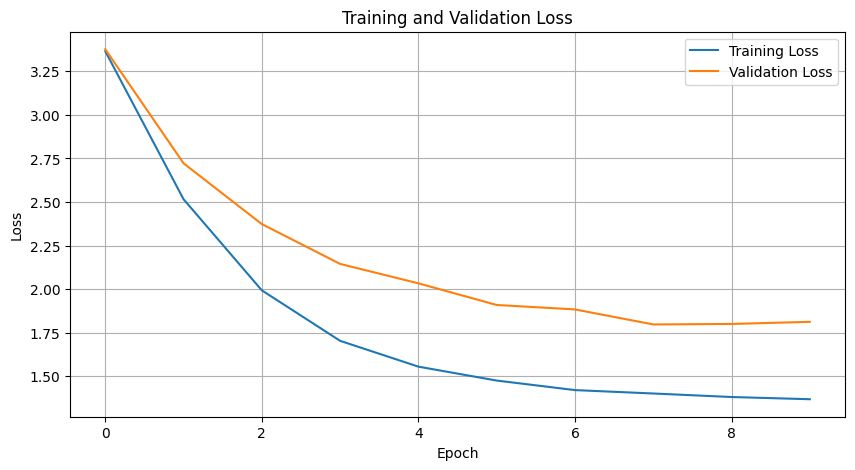

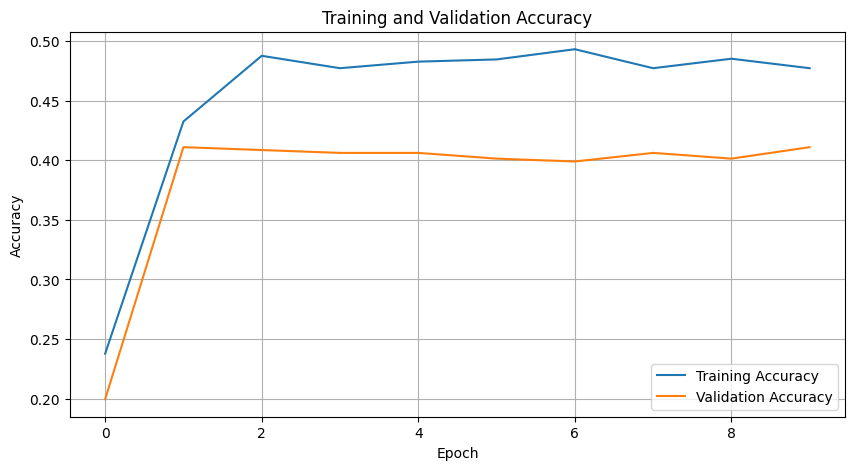

# Auxiliary Functions

In [ ]:
import gc

# Rerunning a cell (e.g. data loading) can sometimes cause mem to increase.
# This can clear some of the unused memory, without getting rid of everything.
gc.collect()


0

# Comments...

UJ: So I tried running model on the whole dataset, but i kept getting used up all ram crash errror. I decrease sample size to 200 videos and it worked. However training and validcation acc being 100 is sus. Aslo the model isn't really the best!

CK: Try the TPU (High-RAM) instance; that worked for me; has WAY more RAM.  (Only available in Pro version of Google Colab).


**Table for parameter tuning/testing**

Varying each parameter independently.  The baseline parameters will be:

num_layers    = 2\
embedding_dim = 1024\
num_heads     = 4\
ff_dim        = 512\
dropout_rate  = 0.1\
learning_rate = 0.0001

batch_size    = 16\
sample_size   = 64\
epochs        = 10\
\
Standard peak validation accuracy: **0.4712** \

\

| Param Testing | Value | Val Acc | Notes                               |
|---------------|-------|---------|-------------------------------------|
| batch_size    | 8     | ?       |                                     |

\

**Notes**:
- Embedding_dims seems to matter more than feedforward
- Maybe 256?
- Ratio not that important; maybe embedding double
- Maybe 8 or 16 heads, rather than 4
- Don't make batch_size too large; maybe 32

# Conclusion

 - Model architecture:

 - Model accuracy:
